# Computer Vision - P3

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **English**.

- The deliverable of both parts must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): November 1st, 23:00 h** 

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics of Laboratory 3 are:

3.1. Segmentation of video shots with static scenes.

3.2. Background subtraction.

3.3. Segmentation of images.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.



## Video segmentation

Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, we ask you to:
- Find the temporal segments of the video (shots). Where the scene change? (Section 3.1)
- Extract the background images and thus, remove all the "artifacts" considered as foreground related to movement. (Section 3.2)




<img src="images/screenshot.png" width=600>

## 3.1 Segmentation of video shots

Read and visualize the sequence of images "images/Barcelona-sequence".

**Hint:** In order to read a collection of images, we wil use the function [animation.FuncAnimation](https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html). Observe in the following Example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

In [1]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation

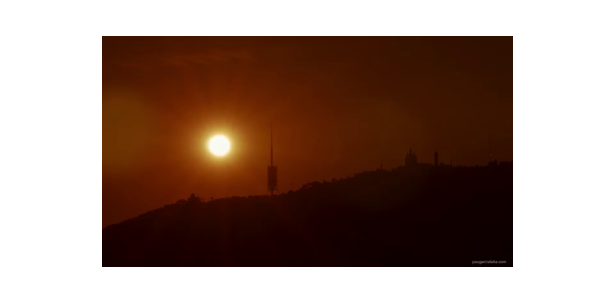

In [2]:
# In VSCode nbagg doesn't work, we'll use widget
%matplotlib widget

# Reading a sequence of images from a folder
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

fig = plt.figure(figsize=(6, 3))        # Create figure
plt.axis('off')
im = plt.imshow(ic[0], animated=True)   # Visualize the first image

def run(i):                 # Updating the frame visualization
    im.set_array(ic[i])     # Changing the content of the canvas
    return im,              # to return a tuple!

# The code execution is slower than 1ms, so if interval=1 then the fps
# are the speed to compute each iteration, which varies notably.
# Because of this we've fixed 24 fps (with interval 1 / 24 * 1000 ms)
INTERVAL_24_FPS = 42
ani = animation.FuncAnimation(fig, run, interval=INTERVAL_24_FPS, blit=True, frames=len(ic), repeat= False)
plt.show()

a) Find where a shot (scene) finishes and the following starts (the shot boundaries). To achieve this goal, we are going to compute the difference between the histograms of consecutive frames. The proposed solution required:

- Compute the histogram for each RGB channel

- The 'total' histogram of the image is computed as the sum of the three histograms

- Compute the mean of the difference (in absolute value) between the histograms of two consecutive frames

Those differences with largest values corresponds to the transitions between shots. 

Therefore, **we need to create a funtion which return an array with the differences between histograms. We will plot the resulting array in order to localice the maximum values as well as a suitable threshold to define localize the transitions.**

<img src="images/histogramshot.png" width=600>
<img src="images/difference_histograms.png">

To solve this exercise, you need to create a **temporal plot** showing a frame by frame difference measure to be defined by you, being applicable to distinguish the shots. Define a criterion to detect the boundaries of the shots and visualize it in a static plot.

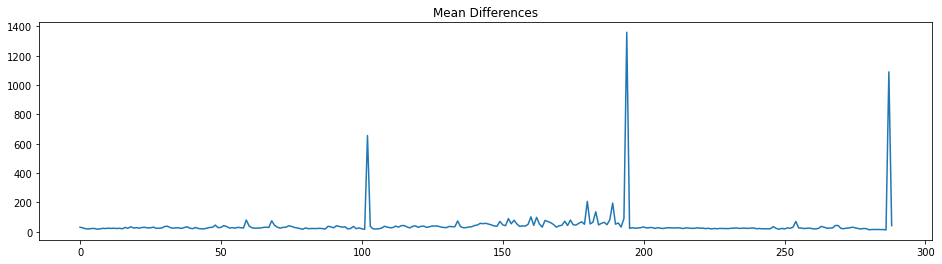

In [3]:
from skimage.exposure import histogram

%matplotlib inline

def align(frequencies, values):
    aligned_frequencies = np.zeros(256)
    aligned_frequencies[values[0]:values[-1]+1] = frequencies
    return aligned_frequencies

mean_differences = []
for i, frame in enumerate(ic):
    # We concatenate the colors so we don't lose information
    new_frequencies = np.concatenate([align(*histogram(frame[:, :, i])) for i in range(3)])
    if i > 0:
        mean_differences.append(np.mean(np.abs(new_frequencies - prev_frequencies)))
    prev_frequencies = new_frequencies

plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(mean_differences)), mean_differences)
plt.title("Mean Differences")
plt.show()

b) Additionally, create an interactive plot executing the following code in "Example A". Substitute the bottom plot with the temporal plot showing the differences between the consecutive frames. 

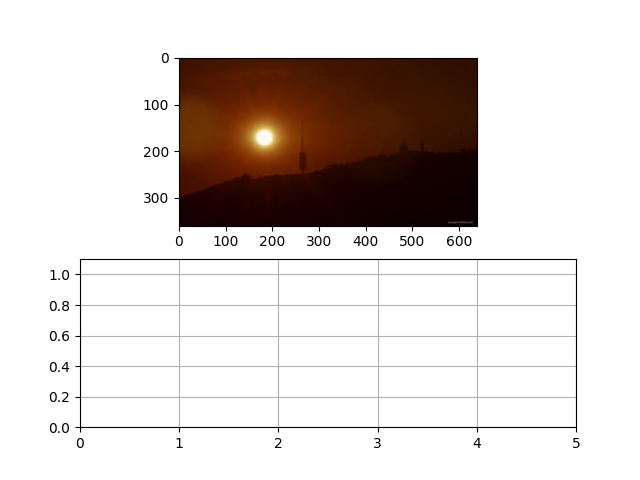

In [4]:
%matplotlib widget

def data_gen():
    return enumerate(mean_differences)

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

im = ax1.imshow(ic[0], animated=True)   # Visualize the first image

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # If not it was extremely slow (it painted everyting every iteration!!!!!)
    im.set_array(ic[data[0]])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
    
    if y >= ymax:
        ax2.set_ylim(ymin,2*ymax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line, im

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=INTERVAL_24_FPS, repeat=False)
plt.show()

c) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


Use the previous plot to define the proper threshold value over the differences of histograms. Use the threshold to localize indexes of the array returned by the function proposed in the previous question and, therefore, localize the initial and final frames for each shot.


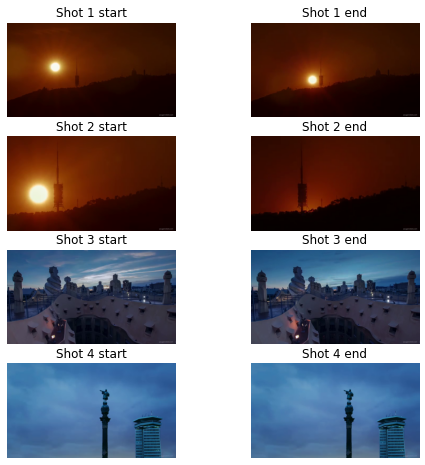

In [5]:
%matplotlib inline

threshold = 400

images = [ic[0]]
for i in range(len(mean_differences)):
    if mean_differences[i] > threshold:
        images.append(ic[i])
        images.append(ic[i+1])
images.append(ic[-1])

fig, axs = plt.subplots(nrows=len(images)//2, ncols=2, figsize=(8, 8))
for i in range(len(images)//2):
    axs[i, 0].imshow(images[2*i])
    axs[i, 1].imshow(images[2*i + 1])

    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

    axs[i, 0].title.set_text(f'Shot {i+1} start')
    axs[i, 1].title.set_text(f'Shot {i+1} end')

plt.show()

d) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

In [10]:
# Your solution here

e) Would your video segmentation strategy be able to separate and track objects? Argue your answer.

In [11]:
# Your solution here

f) Would your video segmentation strategy be able to capture continuous transition? Argue your answer.

In [12]:
# Your solution here

## 3.2 Background subtraction

Apply the background subtraction algorithm (check theory material).

<img src="images/screenshot2.png" width=500>

a) Visualize the following images for each different scene of the video:

    1) an image belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

In [13]:
# Your solution here

b) What do the static background images represent? 

In [14]:
# Your solution here

c) What happens if the shots are not correctly extracted? And, what happens if you find too many shots in the video? 

In [15]:
# Your solution here

d) What happens if you subtract the background image from the original one?

In [16]:
# Your solution here

e) In which situations does the algorithm work and in which it does not? Do you see any additional application for this algorithm?

In [17]:
# Your solution here

f) **[OPTIONAL]**
- Apply the algorithm to some other video that you found.

In [18]:
# Your solution here


## 3.3 Segmentation of images

Apply the image segmentation methods (Felzenswhalbs, Slic and Quickshift) based on the clustering of points corresponding to the pixels but in the feature space RGB-XY space.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline).

<img src="images/image_Segmentation.png" width=600>

### Felzenszwalb's efficient graph based segmentation

a) Read 'rocki.jpeg' image from the folder 'images' and segment it using the Felzenszwalbs's method. Comment the result.


In [19]:
# Your solution here

b) Test and explore different parameters in order to obtain a good image segmentation up to you. 
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?
- Is it critical to convert the image in float in order to do the image segmentation?
- Which are the optimal values according to your subjective perception?
- How does each parameter behave?

Note: You can reduce the size of the image in order to accelerate the running. Does the image reduction affect the optimal values? 



In [20]:
# Your solution here

c) Comment the definition of the algorithm (use approximately 3 lines at most), its advantages and disadvantages.

In [21]:
# Your solution here

### SLIC - K-Means based image segmentation
d) Segment the same image using the SLIC image segmentation algorithm using the parameters by default. 

In [22]:
# Your solution here

e) Explore what are the parameters of the slic function. Test different values for these parameters in order to obtain a good image segmentation with SLIC algorithm.
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?
- Is it critical to convert the image in float in order to do the image segmentation?
- Which are the optimal values of the optional valriables?
- How does each parameter behave?

In [23]:
# Your solution here

f) Comment what the algorithm is (in up to 3 lines).

In [24]:
# Your solution here

### Quickshift image segmentation

g) Segment the same image using the Quickshift algorithm. 

In [25]:
# Your solution here

h) Test different parameters in order to obtain a good image segmentation with Quickshift algorithm.
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?

In [26]:
# Your solution here

i) Comment what the algorithm is (in up to 3 lines).

In [27]:
# Your solution here

### Comparison of segmentation algorithms
j) Plot the original image and the results of both algorithms in a 1x3 subplot using the optimal values.

In [28]:
# Your solution here

k) Calculate also the number of segments obtained on the image by each of the algorithms. Can the number of segments can be used as a criterion for the performance of the algorithms?

In [29]:
# Your solution here

l) Comment the differences between each method as well as their advantages and disadvantages.

In [30]:
# Your solution here

m) Choose another couple of color and grayscale images from the folder 'images' as well as from internet and apply the three segmentation methods. Comment the results.

In [31]:
# Your solution here